# RiskGrid - Data Exploration & Understanding
## Notebook 01: Initial Data Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

## Set display options

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("=" * 40)
print("RISKGRID - Phase 1: Data Exploration")
print("=" * 40)

RISKGRID - Phase 1: Data Exploration


# 1. LOAD THE DATA

In [8]:
print("\n[1] Loading Chicago Crime Dataset...")
DATA_PATH = r"A:\Work\RiskGrid\data\raw\chicago_crimes.csv"

# Load first chunk to inspect
df = pd.read_csv(DATA_PATH)
print(f"✓ Loaded {len(df):,} rows for exploration")


[1] Loading Chicago Crime Dataset...
✓ Loaded 8,421,455 rows for exploration


# 2. INSPECT STRUCTURE

In [12]:
print("\n[2] Dataset Structure:")
print("-" * 60)
print(df.info())

print("\n[3] First Few Records:")
print("-" * 60)
print(df.head())

print("\n[4] Column Names:")
print(df.columns.tolist())


[2] Dataset Structure:
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8421455 entries, 0 to 8421454
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Case Number           object 
 2   Date                  object 
 3   Block                 object 
 4   IUCR                  object 
 5   Primary Type          object 
 6   Description           object 
 7   Location Description  object 
 8   Arrest                bool   
 9   Domestic              bool   
 10  Beat                  int64  
 11  District              float64
 12  Ward                  float64
 13  Community Area        float64
 14  FBI Code              object 
 15  X Coordinate          float64
 16  Y Coordinate          float64
 17  Year                  int64  
 18  Updated On            object 
 19  Latitude              float64
 20  Longitude             float

# 3. KEY COLUMNS ANALYSIS

In [17]:
print("\n[5] Missing Values:")
print("-" * 60)
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
}).sort_values('Percentage', ascending=False)
print(missing_df[missing_df['Missing Count'] > 0])


[5] Missing Values:
------------------------------------------------------------
                      Missing Count  Percentage
Ward                         614822    7.300662
Community Area               613687    7.287185
Location                      93813    1.113976
Longitude                     93813    1.113976
Latitude                      93813    1.113976
Y Coordinate                  93813    1.113976
X Coordinate                  93813    1.113976
Location Description          14976    0.177832
District                         47    0.000558


# 4. DATE/TIME ANALYSIS

In [19]:
print("\n[6] Date/Time Analysis:")
print("-" * 60)
# Find the date column (might be 'Date', 'Date Time', etc.)
date_columns = [col for col in df.columns if 'date' in col.lower()]
print(f"Date columns found: {date_columns}")

if date_columns:
    date_col = date_columns[0]
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    
    print(f"\nDate Range:")
    print(f"  Earliest: {df[date_col].min()}")
    print(f"  Latest: {df[date_col].max()}")
    print(f"  Span: {(df[date_col].max() - df[date_col].min()).days} days")
    
    # Extract temporal features
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    df['day'] = df[date_col].dt.day
    df['hour'] = df[date_col].dt.hour
    df['dayofweek'] = df[date_col].dt.dayofweek
    
    print("\n[7] Temporal Distribution:")
    print(f"  Years: {sorted(df['year'].dropna().unique())}")
    print(f"  Total unique dates: {df[date_col].dt.date.nunique()}")


[6] Date/Time Analysis:
------------------------------------------------------------
Date columns found: ['Date', 'Updated On']

Date Range:
  Earliest: 2001-01-01 00:00:00
  Latest: 2025-10-07 00:00:00
  Span: 9045 days

[7] Temporal Distribution:
  Years: [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
  Total unique dates: 9046


# 5. GEOGRAPHIC ANALYSIS

In [ ]:
print("\n[8] Geographic Coverage:")
print("-" * 60)

# Find lat/lon columns
lat_col = [col for col in df.columns if 'lat' in col.lower()][0] if any('lat' in col.lower() for col in df.columns) else None
lon_col = [col for col in df.columns if 'lon' in col.lower()][0] if any('lon' in col.lower() for col in df.columns) else None

if lat_col and lon_col:
    print(f"Coordinate columns: {lat_col}, {lon_col}")
    
    # NULL Removal
    valid_coords = df[[lat_col, lon_col]].dropna()
    
    print(f"\nValid coordinates: {len(valid_coords):,} / {len(df):,} ({len(valid_coords)/len(df)*100:.1f}%)")
    print(f"\nBounding Box:")
    print(f"  Latitude:  {valid_coords[lat_col].min():.4f} to {valid_coords[lat_col].max():.4f}")
    print(f"  Longitude: {valid_coords[lon_col].min():.4f} to {valid_coords[lon_col].max():.4f}")
    
    # Calculate area coverage (approx)
    lat_range = valid_coords[lat_col].max() - valid_coords[lat_col].min()
    lon_range = valid_coords[lon_col].max() - valid_coords[lon_col].min()
    
    # 1 degree lat ≈ 111km, 1 degree lon at Chicago ≈ 85km
    area_km2 = lat_range * 111 * lon_range * 85
    print(f"  Approximate coverage: {area_km2:.1f} km²")


[8] Geographic Coverage:
------------------------------------------------------------
Coordinate columns: Latitude, Longitude

Valid coordinates: 8,327,642 / 8,421,455 (98.9%)

Bounding Box:
  Latitude:  36.6194 to 42.0229
  Longitude: -91.6866 to -87.5245
  Approximate coverage: 212187.6 km²


# 6. CRIME TYPE ANALYSIS

In [21]:
print("\n[9] Incident Categories:")
print("-" * 60)

# Find crime type column
type_columns = [col for col in df.columns if any(x in col.lower() for x in ['type', 'category', 'primary'])]
if type_columns:
    crime_col = type_columns[0]
    print(f"Using column: '{crime_col}'")
    
    top_crimes = df[crime_col].value_counts().head(15)
    print("\nTop 15 Incident Types:")
    for crime, count in top_crimes.items():
        print(f"  {crime:30s} : {count:6,} ({count/len(df)*100:5.2f}%)")
    
    print(f"\nTotal unique types: {df[crime_col].nunique()}")


[9] Incident Categories:
------------------------------------------------------------
Using column: 'Primary Type'

Top 15 Incident Types:
  THEFT                          : 1,787,597 (21.23%)
  BATTERY                        : 1,534,566 (18.22%)
  CRIMINAL DAMAGE                : 957,673 (11.37%)
  NARCOTICS                      : 763,678 ( 9.07%)
  ASSAULT                        : 564,174 ( 6.70%)
  OTHER OFFENSE                  : 525,081 ( 6.24%)
  BURGLARY                       : 445,303 ( 5.29%)
  MOTOR VEHICLE THEFT            : 430,507 ( 5.11%)
  DECEPTIVE PRACTICE             : 387,756 ( 4.60%)
  ROBBERY                        : 314,518 ( 3.73%)
  CRIMINAL TRESPASS              : 226,593 ( 2.69%)
  WEAPONS VIOLATION              : 124,894 ( 1.48%)
  PROSTITUTION                   : 70,414 ( 0.84%)
  OFFENSE INVOLVING CHILDREN     : 60,449 ( 0.72%)
  PUBLIC PEACE VIOLATION         : 54,772 ( 0.65%)

Total unique types: 34


# 7. VISUALIZATION: TEMPORAL PATTERNS


[10] Generating Visualizations...
------------------------------------------------------------


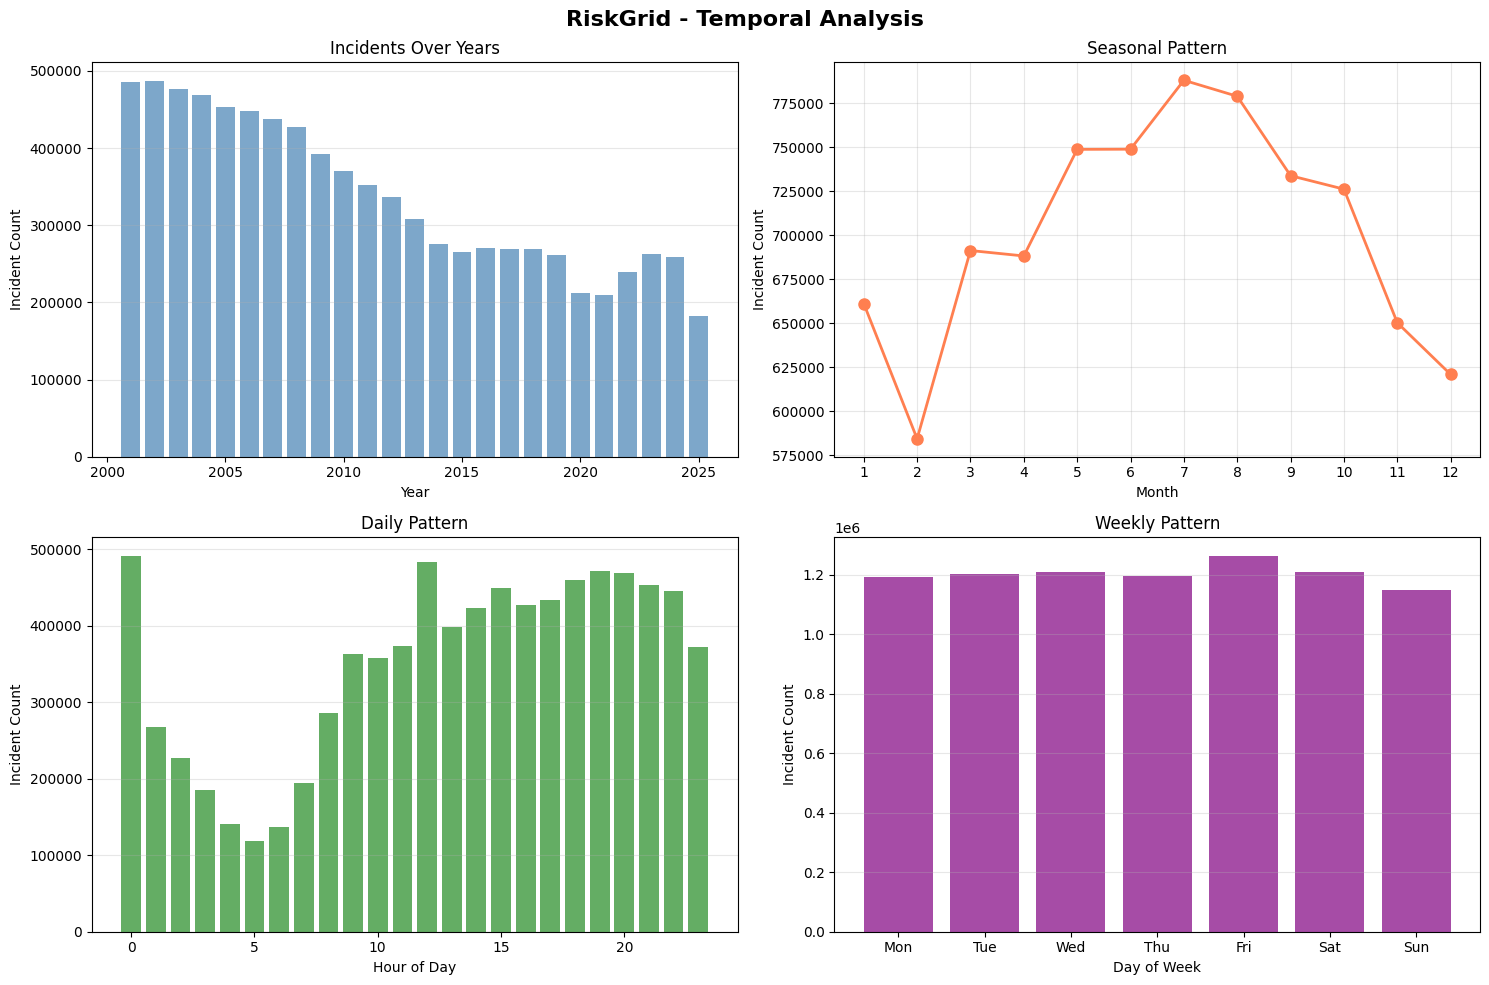

✓ Visualization saved to: outputs/temporal_patterns.png


In [22]:
print("\n[10] Generating Visualizations...")
print("-" * 60)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('RiskGrid - Temporal Analysis', fontsize=16, fontweight='bold')

# Plot 1: Incidents by Year
if 'year' in df.columns:
    yearly = df['year'].value_counts().sort_index()
    axes[0, 0].bar(yearly.index, yearly.values, color='steelblue', alpha=0.7)
    axes[0, 0].set_xlabel('Year')
    axes[0, 0].set_ylabel('Incident Count')
    axes[0, 0].set_title('Incidents Over Years')
    axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Incidents by Month
if 'month' in df.columns:
    monthly = df['month'].value_counts().sort_index()
    axes[0, 1].plot(monthly.index, monthly.values, marker='o', linewidth=2, markersize=8, color='coral')
    axes[0, 1].set_xlabel('Month')
    axes[0, 1].set_ylabel('Incident Count')
    axes[0, 1].set_title('Seasonal Pattern')
    axes[0, 1].set_xticks(range(1, 13))
    axes[0, 1].grid(alpha=0.3)

# Plot 3: Incidents by Hour of Day
if 'hour' in df.columns:
    hourly = df['hour'].value_counts().sort_index()
    axes[1, 0].bar(hourly.index, hourly.values, color='forestgreen', alpha=0.7)
    axes[1, 0].set_xlabel('Hour of Day')
    axes[1, 0].set_ylabel('Incident Count')
    axes[1, 0].set_title('Daily Pattern')
    axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Incidents by Day of Week
if 'dayofweek' in df.columns:
    weekly = df['dayofweek'].value_counts().sort_index()
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    axes[1, 1].bar(range(7), [weekly.get(i, 0) for i in range(7)], 
                   color='purple', alpha=0.7)
    axes[1, 1].set_xlabel('Day of Week')
    axes[1, 1].set_ylabel('Incident Count')
    axes[1, 1].set_title('Weekly Pattern')
    axes[1, 1].set_xticks(range(7))
    axes[1, 1].set_xticklabels(days)
    axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/temporal_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved to: outputs/temporal_patterns.png")

# 8. SUMMARY STATISTICS

In [ ]:
print("\n[11] Summary Report:")
print("=" * 45)
print(f"Total Records Analyzed: {len(df):,}")
print(f"Date Range: {df[date_col].min().date()} to {df[date_col].max().date()}")
print(f"Geographic Coverage: ~{area_km2:.0f} km²")
print(f"Unique Incident Types: {df[crime_col].nunique()}")
print(f"Records with Valid Coordinates: {len(valid_coords):,} ({len(valid_coords)/len(df)*100:.1f}%)")

print("\n" + "=" * 45)
print("✓ Data Exploration Complete!")
print("=" * 45)
print("\nNext Steps:")
print("  1. Review the temporal patterns visualization")
print("  2. Check if data needs cleaning (nulls, outliers)")
print("  3. Proceed to Phase 2: Grid Generation")


[11] Summary Report:
Total Records Analyzed: 8,421,455
Date Range: 2001-01-01 to 2025-10-07
Geographic Coverage: ~212188 km²
Unique Incident Types: 34
Records with Valid Coordinates: 8,327,642 (98.9%)

✓ Data Exploration Complete!

Next Steps:
  1. Review the temporal patterns visualization
  2. Check if data needs cleaning (nulls, outliers)
  3. Proceed to Phase 2: Grid Generation


In [24]:
print("Column names:")
print(df.columns.tolist())
print("\nSample row:")
print(df.iloc[0])

Column names:
['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type', 'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate', 'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude', 'Location', 'year', 'month', 'day', 'hour', 'dayofweek']

Sample row:
ID                                           13995556
Case Number                                  JJ449187
Date                              2025-10-07 00:00:00
Block                              076XX S CICERO AVE
IUCR                                             0860
Primary Type                                    THEFT
Description                              RETAIL THEFT
Location Description               SMALL RETAIL STORE
Arrest                                          False
Domestic                                        False
Beat                                              833
District                                          8.0
Ward   